# ORCA12 spinup phase

In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
from scipy.interpolate import griddata

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39771 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:41811 Dashboard: http://127.0.0.1:39771/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
plt.style.use('dark_background')

## Read mesh

In [3]:
ds_m = xr.open_dataset('/gxfs_work1/geomar/smomw352/mask_orca12.nc')
tmask = ds_m['tmask'][0,:,:,:]
ds_h = xr.open_dataset('/gxfs_work1/geomar/smomw352/mesh_hgr_orca12.nc')
e1t = ds_h['e1t'][0,:,:]
e2t = ds_h['e2t'][0,:,:]

## Read data

In [5]:
expnames = ['FOCI_GJK012','FOCI_BJK017','FOCI_BJK019']
times = [slice('1950-02-01','1959-12-31'),slice('1950-02-01','1952-12-31'),slice('1953-01-01','1959-12-31')]

In [6]:
oifs_1m_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/oifs/' % (exp,)
    files = '%s/*_1m_*_regular_sfc.nc' % (ddir,)
    print(files)
    f = xr.open_mfdataset(files,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    
    oifs_1m_all.append(f)

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK012/outdata/oifs//*_1m_*_regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/oifs//*_1m_*_regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/oifs//*_1m_*_regular_sfc.nc


In [7]:
oifs_1m_all = [oifs_1m_all[0], xr.concat(oifs_1m_all[1:], dim='time')]

In [11]:
ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/oifs/' % ('FOCI_GJK012',)
files = '%s/*_1m_*_regular_sfc.nc' % (ddir,)
print(files)
oifs_1m_lr = xr.open_mfdataset(files,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=slice('1950-01-01','1956-12-31'))

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_GJK012/outdata/oifs//*_1m_*_regular_sfc.nc


In [9]:
times = slice('1950-01-01','1960-01-01')
en4 = '/gxfs_work1/geomar/smomw352/en4/EN.4.2.1.f.analysis.g10.*.nc'
ds_e = xr.open_mfdataset(en4,combine='by_coords').sel(time=times)

## North Atlantic corner

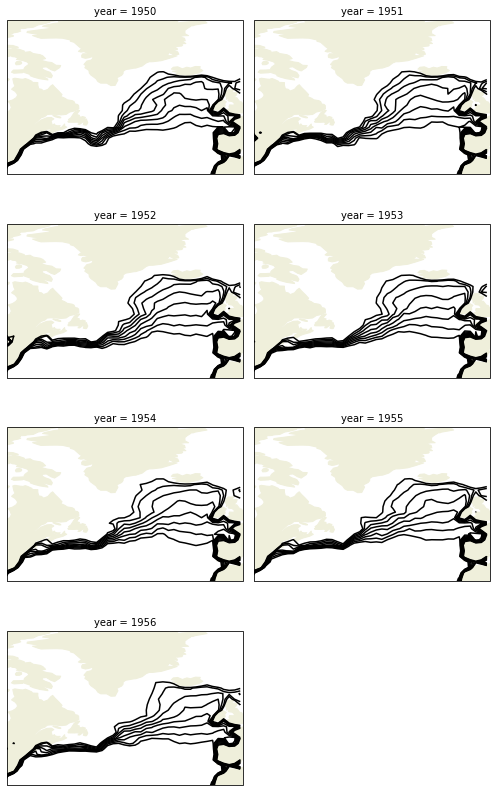

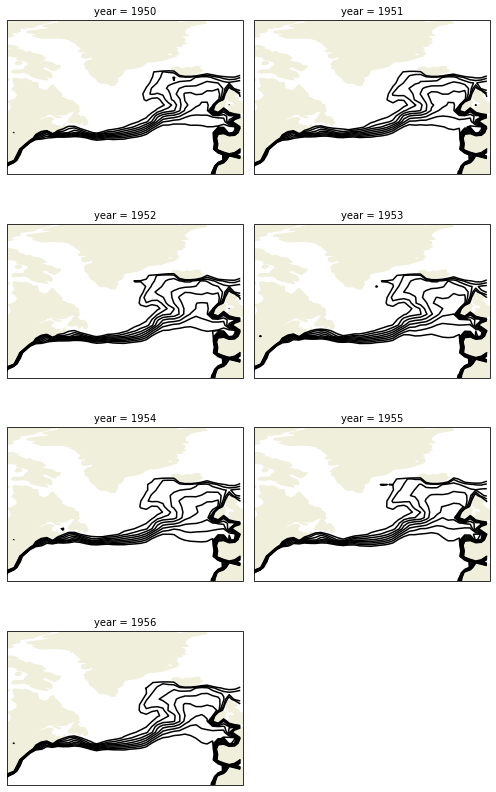

In [35]:
for ji, ds in enumerate( [oifs_1m_sfc, oifs_1m_lr] ):
    
    #fig1, ax1 = plt.subplots(1,1, figsize=(8,3), subplot_kw={'projection':ccrs.PlateCarree()})
    
    sst = ds['sstk'].groupby('time.year').mean('time') - 273.15
    
    p = sst.plot.contour(col='year', col_wrap=2, 
                         levels=np.arange(7,15,1), colors='k',
                         subplot_kws={'projection':ccrs.PlateCarree()},
                         transform=ccrs.PlateCarree())
    
    for ax in p.axes.flat:
        ax.add_feature(cfeature.LAND)
        ax.set_extent([-80,0,30,80])
    
    
    p.fig.tight_layout()
    p.fig.savefig('figures/Natl_sst_%d.pdf' % (ji,),format='pdf',dpi=150)

## SST diff

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


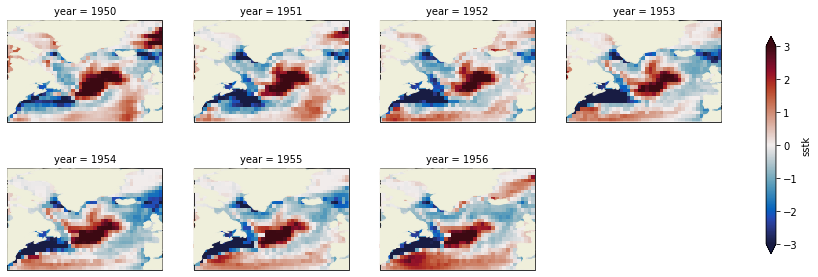

In [48]:
sst_hr = oifs_1m_sfc['sstk'].groupby('time.year').mean('time')
sst_lr = oifs_1m_lr['sstk'].groupby('time.year').mean('time')

dsst = sst_hr - sst_lr.mean('year')

cbar_kwargs = {'shrink':0.8}
p = dsst.plot.pcolormesh(col='year', col_wrap=4, 
                         vmin=-3,vmax=3, cmap=cmocean.cm.balance,
                         subplot_kws={'projection':ccrs.PlateCarree()},
                         figsize=(16,5),
                         cbar_kwargs=cbar_kwargs,
                         transform=ccrs.PlateCarree())
    
for ax in p.axes.flat:
    ax.add_feature(cfeature.LAND,zorder=100)
    ax.set_extent([-80,0,30,80])
    
p.fig.tight_layout()
p.fig.savefig('figures/Natl_sst_hr-lr.pdf',format='pdf',dpi=150)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/plot/facetgrid.py:392: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


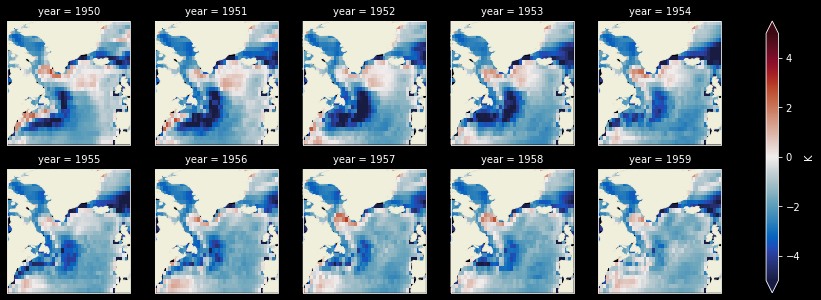

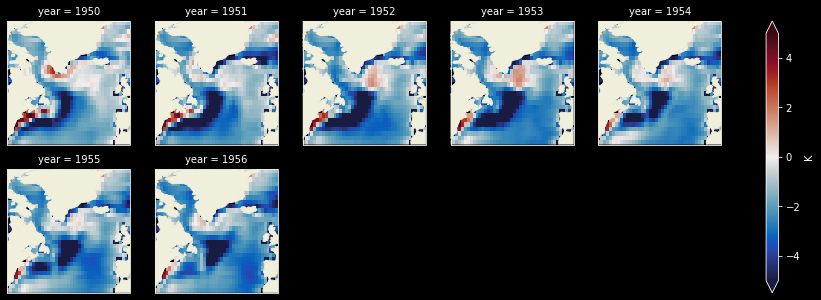

In [14]:
sst_hr = oifs_1m_sfc['sstk'].groupby('time.year').mean('time')
sst_lr = oifs_1m_lr['sstk'].groupby('time.year').mean('time')
sst_obs = ds_e['temperature'].sel(depth=0,method='nearest').mean('time')

dsst_hr = sst_hr - sst_obs.interp_like(sst_hr)
dsst_lr = sst_lr - sst_obs.interp_like(sst_lr)

cbar_kwargs = {'shrink':1, 'extend':'both', 'label':'K'}
p1 = dsst_hr.plot.pcolormesh(col='year', col_wrap=5, 
                             vmin=-5,vmax=5, cmap=cmocean.cm.balance,
                             subplot_kws={'projection':ccrs.PlateCarree()},
                             figsize=(16,5),
                             rasterized=True,
                             cbar_kwargs=cbar_kwargs,
                             transform=ccrs.PlateCarree())

p2 = dsst_lr.plot.pcolormesh(col='year', col_wrap=5, 
                             vmin=-5,vmax=5, cmap=cmocean.cm.balance,
                             subplot_kws={'projection':ccrs.PlateCarree()},
                             figsize=(16,5),
                             cbar_kwargs=cbar_kwargs,
                             rasterized=True,
                             transform=ccrs.PlateCarree())

for p in [p1,p2]:
    for ax in p.axes.flat:
        ax.add_feature(cfeature.LAND,zorder=100)
        ax.set_extent([-80,0,30,80])
        ax.set_aspect('auto')
    
    p.fig.tight_layout()

p1.fig.savefig('figures/Natl_sst_hr.pdf',format='pdf',dpi=150)
p2.fig.savefig('figures/Natl_sst_lr.pdf',format='pdf',dpi=150)


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(193,) (96, 193)


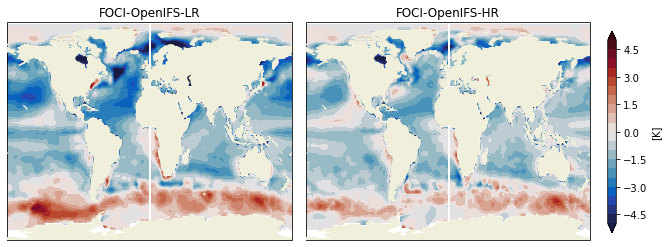

In [22]:
sst_hr = oifs_1m_all[1]['sstk'].sel(time=slice('1955-01-01','1960-01-01')).mean('time')
sst_lr = oifs_1m_all[0]['sstk'].sel(time=slice('1955-01-01','1960-01-01')).mean('time')
sst_obs = ds_e['temperature'].sel(depth=0,method='nearest').mean('time')

dsst_hr = sst_hr - sst_obs.interp_like(sst_hr)
dsst_lr = sst_lr - sst_obs.interp_like(sst_lr)

cbar_kwargs = {'shrink':1, 'extend':'both', 'label':'[K]'}
                                
fig1, ax1 = plt.subplots(1,2,figsize=(12,4),subplot_kw={'projection':ccrs.PlateCarree()})
fig1.subplots_adjust(wspace=0.05,right=0.8)
cax1 = fig1.add_axes([0.82, 0.15, 0.01, 0.7])

cdata_lr, clon = cutil.add_cyclic_point(dsst_lr, coord=dsst_lr.lon)
clat = dsst_lr.lat
print(clon.shape, cdata_lr.shape)

cdata_hr, clon = cutil.add_cyclic_point(dsst_hr, coord=dsst_hr.lon)
clat = dsst_lr.lat

levels = np.arange(-5, 5.5, 0.5)
cf = ax1[0].contourf(clon, clat, cdata_lr, 
                     levels=levels, 
                     cmap=cmocean.cm.balance,
                     extend='both',
                     transform=ccrs.PlateCarree())

cf = ax1[1].contourf(clon, clat, cdata_hr, 
                     levels=levels, 
                     cmap=cmocean.cm.balance,
                     extend='both',
                     transform=ccrs.PlateCarree())

cb = plt.colorbar(cf, cax=cax1)
cb.set_label('[K]')

#cdata_lr.plot.pcolormesh(ax=ax1[0],
#                        vmin=-5,vmax=5, cmap=cmocean.cm.balance,
#                        cbar_kwargs=cbar_kwargs,
#                        rasterized=True,
#                        transform=ccrs.PlateCarree())

ax1[1].set_title('FOCI-OpenIFS-HR')
ax1[0].set_title('FOCI-OpenIFS-LR')

for ax in ax1:
    ax.add_feature(cfeature.LAND,zorder=100)
    #ax.set_extent([-80,0,30,80])
    ax.set_aspect('auto')

#fig1.tight_layout()
fig1.savefig('figures/SST_bias_last5years.pdf',format='pdf',dpi=150)